<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/Projet_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import shutil
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor
from sklearn.cluster import KMeans

In [2]:
shutil.rmtree('/content/metadata', ignore_errors=True)
shutil.rmtree('/content/train', ignore_errors=True)
shutil.rmtree('/content/validation', ignore_errors=True)

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/wider_face_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/metadata/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/train/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_val.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/validation/')

In [4]:
features = 16
image_size = 256
ignore_threshold = 0.5
batch_size = 32
epochs = 30
k = 5
test_nb_images = 10

In [5]:
def get_right_images(filepath_train, filepath_val, top_path_train, top_path_val):
  map_filename_bbx = {}
  for filepath, top_path in zip([filepath_train, filepath_val], [top_path_train, top_path_val]):
    with open(filepath) as file:
      lines = file.read().splitlines()
      file_name_line_number = 0
      face_line_number = 0
      while file_name_line_number < len(lines):
        number_of_faces = int(lines[file_name_line_number + 1])
        if number_of_faces is 0:
          number_of_faces += 1
        values = []
        key = lines[file_name_line_number]
        while face_line_number < number_of_faces:
          fields = lines[file_name_line_number + 2 + face_line_number].split()
          fields = list(map(int, fields))
          if fields[4] is not 0 or fields[5] is not 0 or fields[6] is not 0 or fields[7] is not 0 or fields[8] is not 0 or fields[9] is not 0:
            face_line_number += 1
            values = []
            break
          value = np.array([x for x in fields[:4]])
          if len(value) > 0:
            values.append(value)
          face_line_number += 1
        if values:
          map_filename_bbx[top_path + key] = values
        file_name_line_number += number_of_faces + 2
        face_line_number = 0
  return map_filename_bbx

In [6]:
def get_aspect_ratio(right_images):
  aspect_ratio_list = []
  for key in list(right_images):
    image_size = Image.open(key).size
    if image_size[0] < image_size[1]:
      del right_images[key]
      continue
    aspect_ratio_list.append(float(image_size[0]) / float(image_size[1]))
  return right_images

In [7]:
def normalize_images(images):
  means = images.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
  stds = images.std(axis=(0,1,2), keepdims=True).astype(np.float32)
  images = (images - means) / stds
  return images.astype(np.float32)

In [8]:
def get_iou(bbx1, bbx2):
  x_left = np.maximum(bbx1[..., 0], bbx2[..., 0])
  y_top = np.maximum(bbx1[..., 1], bbx2[..., 1])
  x_right = np.minimum(bbx1[..., 0] + bbx1[..., 2], bbx2[..., 0] + bbx2[..., 2])
  y_bottom = np.minimum(bbx1[..., 1] + bbx1[..., 3], bbx2[..., 1] + bbx2[..., 3])

  intersection_area = (np.maximum(np.zeros(x_right.shape), x_right - x_left) * np.maximum(np.zeros(y_bottom.shape), y_bottom - y_top)).astype(np.float32)

  bbx1_area = bbx1[..., 2] * bbx1[..., 3]
  bbx2_area = bbx2[..., 2] * bbx2[..., 3]

  iou = intersection_area / (bbx1_area + bbx2_area - intersection_area)
  iou = np.nan_to_num(iou)
  return iou

In [9]:
def get_iou_not_same_shape(boxes, predictions):

    boxes = tf.expand_dims(boxes, 0)
    predictions = tf.expand_dims(predictions, 1)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(predictions), tf.shape(boxes))
    boxes = tf.broadcast_to(boxes, new_shape)
    predictions = tf.broadcast_to(predictions, new_shape)

    x_box = boxes[..., 0]
    y_box = boxes[..., 1]
    w_box = boxes[..., 2]
    h_box = boxes[..., 3]

    #print(tf.unique(tf.reshape(w_box, (-1,))))
    #print(tf.unique(tf.reshape(h_box, (-1,))))
    #print('*********************************************')
    x_pred = predictions[..., 0]
    y_pred = predictions[..., 1]
    w_pred = predictions[..., 2]
    h_pred = predictions[..., 3]

    x_left = tf.math.maximum(x_box, x_pred)
    y_top = tf.math.maximum(y_box, y_pred)
    x_right = tf.math.minimum(x_box + w_box, x_pred + w_pred)
    y_bottom = tf.math.minimum(y_box + h_box, y_pred + h_pred)

    intersection_area = tf.math.maximum(0, x_right - x_left) * tf.math.maximum(0, y_bottom - y_top)

    boxes_area = w_box * h_box
    predictions_area = w_pred * h_pred

    union = boxes_area + predictions_area - intersection_area

    iou = intersection_area / union
    #iou = tf.where(tf.math.is_nan(iou), tf.ones_like(iou) * 0, iou)

    return iou

In [10]:
class Preprocessing:

  def __init__(self, image_size, features):
    self.image_size = image_size
    self.features = features
    self.cell_size = 1.0 / features

  def set_labels(self, bbx_list, anchors):
    Y = np.zeros((len(bbx_list), self.features, self.features, len(anchors), 5), dtype=np.float32)
    anchors = np.concatenate([np.zeros(anchors.shape), anchors], axis=1)
    #anchors[:, 2:] = anchors[:, 2:] * self.image_size
    for image_index, bbxs in enumerate(bbx_list):
      for i in range(0, self.features):
        cell_row_min = i * self.cell_size
        cell_row_max = min((i + 1) * self.cell_size, 1.0)
        for j in range(0, self.features):
          cell_col_min = j * self.cell_size
          cell_col_max = min((j + 1) * self.cell_size, 1.0)
          for t in range(bbxs.shape[0]):
            bbx = bbxs[t]
            object_midpoint = np.array([bbx[0] + (bbx[2] / 2), bbx[1] + (bbx[3] / 2)])
            if cell_row_min < object_midpoint[1] < cell_row_max and cell_col_min < object_midpoint[0] < cell_col_max:
              anchors[:, 0] = np.maximum(np.zeros((anchors.shape[0],)), np.repeat(object_midpoint[0], anchors.shape[0], axis=0) - (anchors[:, 2] / 2))
              anchors[:, 1] = np.maximum(np.zeros((anchors.shape[0],)), np.repeat(object_midpoint[1], anchors.shape[0], axis=0) - (anchors[:, 3] / 2))
              object_box = np.repeat(bbx.reshape((1, 4)), anchors.shape[0], axis=0)
              iou = get_iou(object_box.astype(np.float32), anchors.astype(np.float32))
              index = np.argmax(iou)
              x_y = object_midpoint
              w_h = bbx[2:]
              Y[image_index, i, j, index, :] = np.array([1, x_y[0], x_y[1], w_h[0], w_h[1]])
    return Y

  def get_images_and_bbxs(self, right_images):
    image_list = []
    bbx_list = []
    for item in right_images.items():
      image = Image.open(item[0])

      image = np.array(image)
      ratio = min(self.image_size / image.shape[1], self.image_size / image.shape[0])
      new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
      image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

      padding_amount_rows = (self.image_size - image.shape[0]) / 2
      padding_amount_cols = (self.image_size - image.shape[1]) / 2

      values = []
      for bbx in item[1]:
        if (bbx==0).all():
          continue
        new_bbx = bbx * ratio
        new_bbx[0] += padding_amount_cols
        new_bbx[1] += padding_amount_rows
        values.append(new_bbx)
      
      if not values:
        continue
      
      bbxs = (np.stack(values) / self.image_size).astype(np.float32)

      image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
      image_list.append(image)
      bbx_list.append(bbxs)
        
    images = np.stack(image_list)
    return images, bbx_list

In [11]:
from sklearn.model_selection import train_test_split

right_images = get_right_images('/content/metadata/wider_face_split/wider_face_train_bbx_gt.txt', '/content/metadata/wider_face_split/wider_face_val_bbx_gt.txt', '/content/data/train/WIDER_train/images/', '/content/data/validation/WIDER_val/images/')
print(len(right_images))
right_images = get_aspect_ratio(right_images)
print(len(right_images))

4771
2727


In [12]:
def get_bbxs_clusters(bbx_list, k, image_size):
  widths_and_heights = []
  for bbx in bbx_list:
    widths_and_heights.append(bbx[:, 2:])
  X = np.concatenate(widths_and_heights, axis=0)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
  return kmeans.cluster_centers_.astype(np.float32).reshape((-1, 2))

In [13]:
preprocessing = Preprocessing(image_size, features)
images, bbx_list = preprocessing.get_images_and_bbxs(right_images)
anchors = get_bbxs_clusters(bbx_list, k, image_size)
print(anchors)
print(images.shape)

[[0.03758509 0.0475527 ]
 [0.14995204 0.20368358]
 [0.40819132 0.52153045]
 [0.24703056 0.3349998 ]
 [0.08625717 0.1174665 ]]
(2720, 256, 256, 3)


In [14]:
Y = preprocessing.set_labels(bbx_list, anchors)
print(len(bbx_list))

2720


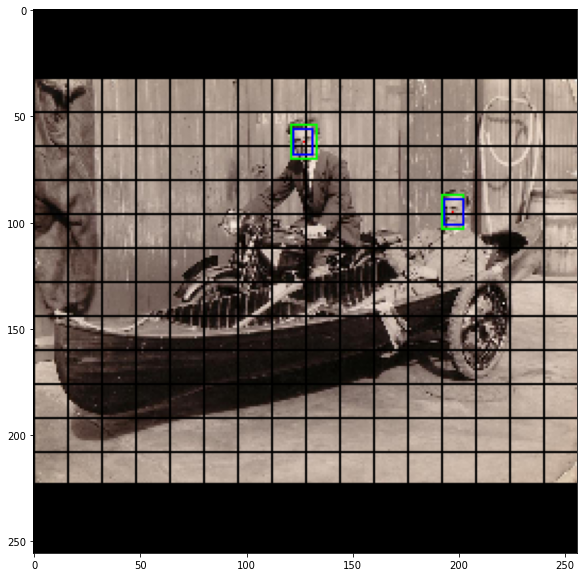

In [15]:
index = np.random.randint(0, Y.shape[0])
cell_size = image_size / features
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
test_image = images[index]
test_image[::int(cell_size), :, :] = 0
test_image[:, ::int(cell_size), :] = 0
Y_test = Y[index]
for i in range(Y_test.shape[0]):
  for j in range(Y_test.shape[1]):
    for t in range(Y_test.shape[2]):
      if Y_test[i, j, t, :].any():
        bbox = Y_test[i, j, t, 1:]
        w_h_box = (anchors[t] * image_size).astype(np.int32)
        w_h_true = (bbox[2:] * image_size).astype(np.int32)
        object_midpoint_x_y = bbox[0:2] * image_size
        test_image[int(object_midpoint_x_y[1]), int(object_midpoint_x_y[0]), :] = np.array([255, 0, 0])
        x_y_true = np.maximum(0, object_midpoint_x_y - (w_h_true / 2)).astype(np.int32)
        x_y_box = np.maximum(0, object_midpoint_x_y - (w_h_box / 2)).astype(np.int32)
        test_image = cv.rectangle(test_image, (x_y_true[0], x_y_true[1]), (x_y_true[0] + w_h_true[0], x_y_true[1] + w_h_true[1]), (0, 255, 0), 1)
        test_image = cv.rectangle(test_image, (x_y_box[0], x_y_box[1]), (x_y_box[0] + w_h_box[0], x_y_box[1] + w_h_box[1]), (0, 0, 255), 1)
ax.imshow(test_image)

In [16]:
images = normalize_images(images)

all_indices = list(range(images.shape[0]))
test_size_percent = test_nb_images / images.shape[0]
train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
X_train_first = images[train_indices, ...]
X_test = images[test_indices, ...]
Y_test = Y[test_indices, ...]
Y_train_first = Y[train_indices, ...]

all_indices = list(range(X_train_first.shape[0]))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)
del all_indices
X_train = X_train_first[train_indices, ...]
X_val = X_train_first[test_indices, ...]
Y_train = Y_train_first[train_indices, ...]
Y_val = Y_train_first[test_indices, ...]
boxes_train = [bbx_list[i] for i in train_indices]
del train_indices, test_indices, Y, images, right_images

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)
print(len(boxes_train))

(2168, 256, 256, 3)
(2168, 16, 16, 5, 5)
(542, 256, 256, 3)
(542, 16, 16, 5, 5)
(10, 256, 256, 3)
(10, 16, 16, 5, 5)
2168


In [17]:
'''def get_object_loss(bo, label, noobj_mask, lambda_obj, lambda_noobj):
  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss_conf_obj = tf.reduce_sum(label * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  loss_conf_noobj = tf.reduce_sum(noobj_mask * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  return (lambda_obj * loss_conf_obj) + (lambda_noobj * loss_conf_noobj)'''

'def get_object_loss(bo, label, noobj_mask, lambda_obj, lambda_noobj):\n  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)\n  loss_conf_obj = tf.reduce_sum(label * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))\n  loss_conf_noobj = tf.reduce_sum(noobj_mask * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))\n  return (lambda_obj * loss_conf_obj) + (lambda_noobj * loss_conf_noobj)'

In [18]:
'''def get_location_loss(label, prediction, t_xy, t_wh, lambda_xy, lambda_wh):
  loss_xy = tf.reduce_sum(label * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
  loss_wh = tf.reduce_sum(label * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))
  return (lambda_xy * loss_xy) + (lambda_wh * loss_wh)'''

'def get_location_loss(label, prediction, t_xy, t_wh, lambda_xy, lambda_wh):\n  loss_xy = tf.reduce_sum(label * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))\n  loss_wh = tf.reduce_sum(label * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))\n  return (lambda_xy * loss_xy) + (lambda_wh * loss_wh)'

In [71]:
def loss(box_list, features, anchors, ignore_threshold):
  def get_loss_sub(label, prediction):
    grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    #grid = tf.tile(grid, (1, 1, anchors.shape[0], 1))

    bx_by = tf.math.sigmoid(prediction[..., 1:3]) + grid
    bx_by = bx_by / tf.cast(features, tf.float32)
    bo = tf.math.sigmoid(prediction[..., 0])
    bw_bh = tf.exp(prediction[..., 3:]) * anchors
    bx_by = tf.maximum(0, bx_by - bw_bh / 2)
    abs_predictions = tf.reshape(tf.concat([bx_by, bw_bh], axis=-1), (label.shape[0], -1, 4))

    ious = []
    for index, boxes in enumerate(box_list):
      current_pred = abs_predictions[index]
      iou = get_iou_not_same_shape(boxes, current_pred)
      if (np.isnan(ious).any()):
        print("PAS OK !")
      ious.append(np.amax(iou, axis=1))
    ious = np.stack(ious).reshape((label.shape[0], features, features, len(anchors)))

    noobj_mask = tf.cast(ious < ignore_threshold, tf.float32) * (1 - label[..., 0])

    t_wh = tf.math.log(label[..., 3:] / anchors)
    t_wh = tf.where(tf.logical_or(tf.math.is_inf(t_wh), tf.math.is_nan(t_wh)), tf.zeros_like(t_wh), t_wh)
    t_xy = label[..., 1:3] * features - grid

    loss_xy = tf.reduce_sum(label[..., 0] * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
    loss_wh = tf.reduce_sum(label[..., 0] * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))

    #location_loss = get_location_loss(label[..., 0], prediction, t_xy, t_wh, 5, 5)

    loss_conf_obj = tf.reduce_sum(label[..., 0] * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    loss_conf_noobj = tf.reduce_sum(noobj_mask * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    #object_loss = get_object_loss(bo, label[..., 0], noobj_mask, 5, 0.5)

    total_loss = 5 * loss_xy + 5 * loss_wh + 5 * loss_conf_obj + 0.5 * loss_conf_noobj
    #total_loss = location_loss + object_loss

    return total_loss

  return get_loss_sub

In [20]:
loos_obj = loss(bbx_list[:32], features, anchors, ignore_threshold)
train_data_test = np.random.rand(32, 16, 16, 5, 5).astype(np.float32)
gt_data_test = np.random.rand(32, 16, 16, 5, 5).astype(np.float32)
out = loos_obj(gt_data_test, train_data_test)

In [21]:
#def resnet_block(inputs, filters, reduce):
#  shortcut = 0
#  if reduce:
#    x = layers.Conv2D(filters, 3, strides=2, padding="same")(inputs)
#    shortcut = layers.Conv2D(filters, 3, strides=2, padding="same")(inputs)
#    shortcut = layers.BatchNormalization()(shortcut)
#  else:
#    x = layers.Conv2D(filters, 3, strides=1, padding="same")(inputs)
#    shortcut = inputs
#
#  x = layers.BatchNormalization()(x)
#  x = layers.LeakyReLU(alpha=0.1)(x)
#
#  x = layers.Conv2D(filters, 3, strides=1, padding="same")(x)
#  x = layers.BatchNormalization()(x)
#
#  x = layers.add([x, shortcut])
#
#  x = layers.LeakyReLU(alpha=0.1)(x)
#
#  return x

In [37]:
def darknetBlock(inputs, filters1, filters2):
  x = layers.Conv2D(filters1, 1, strides=1, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)

  x = layers.Conv2D(filters2, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  
  x = layers.add([inputs, x])
  return x

In [30]:
def convBlock(inputs, filters, strides):
  x = layers.Conv2D(filters, 3, strides=strides, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  return x

In [72]:
from tensorflow.keras.layers import concatenate

def get_model(image_size, features, anchors):

    inputs = keras.Input((image_size, image_size, 3))

    x = convBlock(inputs, 32, 1)
    x = convBlock(x, 64, 2)

    x = darknetBlock(x, 32, 64)
    x = convBlock(x, 128, 2)

    for i in range(2):
      x = darknetBlock(x, 64, 128)

    x = convBlock(x, 256, 2)

    for i in range(8):
      x = darknetBlock(x, 128, 256)

    x = convBlock(x, 512, 2)

    #for i in range(4):
    #  x = darknetBlock(x, 256, 512)

    #x = resnet_block(x, 32, True)
    #x = resnet_block(x, 32, False)
#
    #x = resnet_block(x, 64, True)
    #x = resnet_block(x, 64, False)
    #x = resnet_block(x, 64, False)
#
    #x = resnet_block(x, 128, True)
    #x = resnet_block(x, 128, False)
    #x = resnet_block(x, 128, False)

    x = layers.Conv2D(len(anchors) * 5, 1, padding='same')(x)
    outputs = layers.Reshape((features, features, len(anchors), 5))(x)

    model = keras.Model(inputs, outputs)
    return model


keras.backend.clear_session()

model = get_model(image_size, features, anchors)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
def convert_grid_to_image_reference(preds, features, anchors):
  grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  bx_by = (tf.math.sigmoid(preds[..., 1:3]) + grid) / features
  bo = tf.math.sigmoid(preds[..., 0])
  bw_bh = tf.exp(preds[..., 3:]) * anchors
  bx_by = tf.maximum(0, bx_by - bw_bh / 2)
  out = tf.concat([tf.expand_dims(bo, axis=-1), bx_by, bw_bh], axis=-1)

  return out

In [78]:
val_acc_metric = keras.metrics.AUC(curve='PR')
train_acc_metric = keras.metrics.AUC(curve='PR')

train_ds=tf.data.Dataset.from_tensor_slices(tf.range(0, X_train.shape[0])).shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
val_ds=tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)
optimizer = keras.optimizers.Adam()

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    running_loss = 0
    # Iterate over the batches of the dataset.
    for step, indices in enumerate(train_ds):

        bbxs = [bbx_list[i] for i in indices]
        x_batch_train = X_train[indices, ...]
        y_batch_train = Y_train[indices, ...]

        loss_function = loss(bbxs, features, anchors, ignore_threshold)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            preds = model(x_batch_train, training=True)

            # Compute the loss value for this minibatch.
            loss_value = loss_function(y_batch_train, preds)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        running_loss += tf.reduce_sum(loss_value) / indices.shape[0]

        preds = convert_grid_to_image_reference(preds, features, anchors)
        ious = get_iou(tf.reshape(y_batch_train[..., 1:], (y_batch_train.shape[0], -1, 4)), tf.reshape(preds[..., 1:], (preds.shape[0], -1, 4)))
        #print(tf.unique(tf.reshape(ious, (-1,))))
        #print('*****************************************************************')
        #print(tf.unique(tf.reshape(y_batch_train[..., 0], (-1,))))

        train_acc_metric.update_state(tf.reshape(y_batch_train[..., 0], ious.shape), ious)

    print(f'Epoch: {epoch}, Loss: {running_loss},', end=' ')
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Train accuracy: %.4f," % (float(train_acc),), end=' ')

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

     # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_ds:
        preds_val = model(x_batch_val, training=False)
        preds_val = convert_grid_to_image_reference(preds_val, features, anchors)
        #print(tf.unique(tf.reshape(preds_val, (-1,))))
        ious = get_iou(tf.reshape(y_batch_val[..., 1:], (y_batch_val.shape[0], -1, 4)), tf.reshape(preds_val[..., 1:], (preds_val.shape[0], -1, 4)))
        # Update val metrics

        #print(tf.unique(tf.reshape(ious, (-1,))))
        #print('*****************************************************************')
        #print(tf.unique(tf.reshape(y_batch_train[..., 0], (-1,))))

        val_acc_metric.update_state(tf.reshape(y_batch_val[..., 0], ious.shape), ious)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    


Start of epoch 0
Epoch: 0, Loss: 483.46051025390625, Train accuracy: 0.9472, Validation acc: 0.9493

Start of epoch 1
Epoch: 1, Loss: 418.8357238769531, Train accuracy: 0.9528, Validation acc: 0.9444

Start of epoch 2
Epoch: 2, Loss: 391.2248840332031, Train accuracy: 0.9561, Validation acc: 0.9396

Start of epoch 3
Epoch: 3, Loss: 341.6084289550781, Train accuracy: 0.9571, Validation acc: 0.9396

Start of epoch 4
Epoch: 4, Loss: 309.22808837890625, Train accuracy: 0.9573, Validation acc: 0.9589

Start of epoch 5
Epoch: 5, Loss: 287.34027099609375, Train accuracy: 0.9598, Validation acc: 0.9356

Start of epoch 6
Epoch: 6, Loss: 262.3095397949219, Train accuracy: 0.9647, Validation acc: 0.9267

Start of epoch 7
Epoch: 7, Loss: 256.12847900390625, Train accuracy: 0.9626, Validation acc: 0.9501

Start of epoch 8
Epoch: 8, Loss: 228.18592834472656, Train accuracy: 0.9659, Validation acc: 0.9315

Start of epoch 9
Epoch: 9, Loss: 225.9969024658203, Train accuracy: 0.9672, Validation acc: 0.

In [79]:
model.save("/content/drive/MyDrive/model_dlim")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_dlim/assets


In [23]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor

model = keras.models.load_model('/content/drive/MyDrive/model_dlim')

In [80]:
def non_max_supression(predictions_boxes, discard_threshold, keep_threshold):
  predictions_boxes = predictions_boxes.reshape(predictions_boxes.shape[0], -1, predictions_boxes.shape[-1])
  kept_boxes_images = []
  for t in range(predictions_boxes.shape[0]):
    kept_boxes = []
    image = predictions_boxes[t]
    image = image[image[:, 0] > discard_threshold]
    while image.shape[0] > 0:
      index = np.argmax(image[..., 0])
      max_box = image[index, :][1:]
      kept_boxes.append(max_box.copy())
      image = np.delete(image, index, axis=0)
      ious = get_iou(np.repeat(max_box.reshape((1, -1)), image.shape[0], axis=0), image[:, 1:])
      image = image[ious < keep_threshold]
    kept_boxes_images.append(kept_boxes)
  return kept_boxes_images

In [ ]:
'''predictions_boxes = np.random.rand(2, 16, 16, 5, 5)
predictions_boxes = predictions_boxes.reshape(predictions_boxes.shape[0], -1, predictions_boxes.shape[-1])
kept_boxes_images = []
for t in range(predictions_boxes.shape[0]):
  kept_boxes = []
  image = predictions_boxes[t]
  image = image[image[:, 0] > 0.5]
  while image.shape[0] > 0:
    index = np.argmax(image[..., 0])
    max_box = image[index, :][1:].reshape((1, -1))
    kept_boxes.append(max_box.copy())
    image = np.delete(image, index, axis=0)
    ious = get_iou(np.repeat(max_box, image.shape[0], axis=0), image[:, 1:])
    image = image[ious < 0.3]
  kept_boxes_images.append(kept_boxes)'''

(624, 4)
(549, 4)
(541, 4)
(470, 4)
(469, 4)
(450, 4)
(437, 4)
(431, 4)
(426, 4)
(425, 4)
(406, 4)
(404, 4)
(355, 4)
(354, 4)
(348, 4)
(315, 4)
(300, 4)
(299, 4)
(298, 4)
(291, 4)
(290, 4)
(287, 4)
(284, 4)
(278, 4)
(277, 4)
(270, 4)
(268, 4)
(266, 4)
(238, 4)
(235, 4)
(234, 4)
(226, 4)
(225, 4)
(221, 4)
(212, 4)
(211, 4)
(210, 4)
(208, 4)
(207, 4)
(202, 4)
(197, 4)
(188, 4)
(186, 4)
(173, 4)
(170, 4)
(169, 4)
(168, 4)
(167, 4)
(165, 4)
(164, 4)
(156, 4)
(149, 4)
(145, 4)
(144, 4)
(141, 4)
(140, 4)
(134, 4)
(133, 4)
(132, 4)
(131, 4)
(129, 4)
(127, 4)
(123, 4)
(122, 4)
(121, 4)
(120, 4)
(116, 4)
(115, 4)
(114, 4)
(111, 4)
(110, 4)
(109, 4)
(108, 4)
(106, 4)
(105, 4)
(104, 4)
(103, 4)
(102, 4)
(101, 4)
(100, 4)
(94, 4)
(93, 4)
(91, 4)
(90, 4)
(89, 4)
(88, 4)
(85, 4)
(84, 4)
(82, 4)
(81, 4)
(80, 4)
(79, 4)
(78, 4)
(77, 4)
(75, 4)
(74, 4)
(73, 4)
(72, 4)
(70, 4)
(67, 4)
(66, 4)
(63, 4)
(62, 4)
(61, 4)
(60, 4)
(59, 4)
(58, 4)
(57, 4)
(56, 4)
(55, 4)
(54, 4)
(52, 4)
(51, 4)
(50, 4)
(49, 4)


In [ ]:
'''grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

bx_by = (tf.math.sigmoid(preds[..., 1:3]) + grid) * (width / width_features)
bo = tf.math.sigmoid(preds[..., 0])
print(np.unique(bo))
bw_bh = (tf.exp(preds[..., 3:]) * anchors) * width
bx_by = tf.maximum(0, bx_by - bw_bh / 2)
preds[..., 1:3] = bx_by
preds[..., 3:] = bw_bh
preds[..., 1:] = tf.cast(preds[..., 1:], tf.int32).numpy()
preds[..., 0] = bo.numpy()'''

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


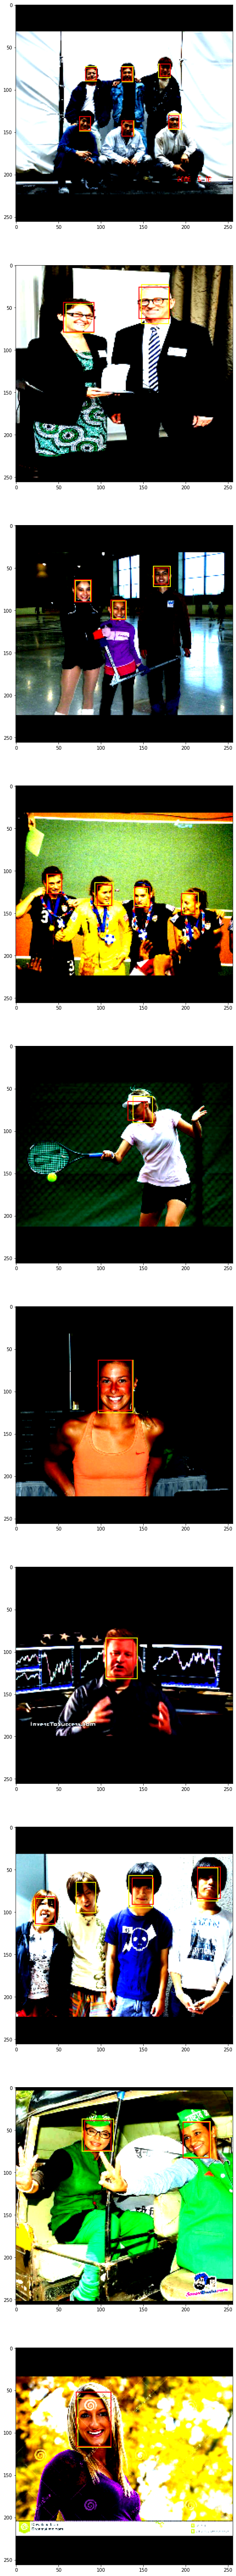

In [81]:
test_acc_metric = keras.metrics.AUC(curve='PR')

preds = model.predict(X_test)

preds = convert_grid_to_image_reference(preds, features, anchors).numpy()
ious = get_iou(Y_test[..., 1:].reshape((Y_test.shape[0], -1, 4)), tf.reshape(preds[..., 1:], (preds.shape[0], -1, 4)))

test_acc_metric.update_state(Y_test[..., 0].reshape(ious.shape), ious)
print(test_acc_metric.result().numpy())

preds[..., 1:] = preds[..., 1:] * image_size

list_boxes = non_max_supression(preds, 0.5, 0.2)

fig, ax = plt.subplots(len(list_boxes), 1, figsize=(24, 100))
for image_index, boxes in enumerate(list_boxes):
  test_image = X_test[image_index]
  true_bbxs = Y_test[image_index]
  for box in boxes:
    test_image = cv.rectangle(test_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 255, 0), 1)
  for i in range(true_bbxs.shape[0]):
    for j in range(true_bbxs.shape[1]):
      for t in range(true_bbxs.shape[2]):
        if true_bbxs[i, j, t, :].any():
          true_box = true_bbxs[i, j, t, 1:]
          true_box = (true_box * image_size).astype(np.int32)
          true_box[:2] = true_box[:2] - (true_box[2:] / 2)
          test_image = cv.rectangle(test_image, (true_box[0], true_box[1]), (true_box[0] + true_box[2], true_box[1] + true_box[3]), (255, 0, 0), 1)
  ax[image_index].imshow(test_image)